# IMPORTS

In [37]:
import tensorflow as tf
import datetime
import time
import cv2
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import os
from collections import Counter
from random import shuffle, randint, seed
from tqdm import tqdm
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.python.framework import graph_util
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
%matplotlib inline

In [38]:
import bz2
import argparse
from tensorflow.keras.utils import get_file
from ffhq_dataset.face_alignment import image_align
from ffhq_dataset.landmarks_detector import LandmarksDetector

In [39]:
print(f'OpenCV version: {cv2.__version__}')
print(f'Tensorflow version: {tf.__version__}')

OpenCV version: 4.1.0
Tensorflow version: 2.0.0


In [40]:
## Gets the repo for aligned images

# !rm -rf sample_data
# !git clone https://github.com/pbaylies/stylegan-encoder

# PREPROCESSING

In [41]:
# Check what folder to use for training and testing images
CHISOM_TRAIN_DIR = 'C:/Users/chiso/MEGA/data/train'
CHISOM_TEST_DIR = 'C:/Users/chiso/MEGA/data/test'
CHISOM_ALIGNED_TRAIN_DIR = 'C:/Users/chiso/MEGA/data/aligned_train'
CHISOM_ALIGNED_TEST_DIR = 'C:/Users/chiso/MEGA/data/aligned_test'

YISI_TRAIN_DIR = 'E:/MegaSync/data/train'
YISI_TEST_DIR = 'E:/MegaSync/data/test'
YISI_ALIGNED_TRAIN_DIR = 'E:/MegaSync/data/aligned_train'
YISI_ALIGNED_TEST_DIR = 'E:/MegaSync/data/aligned_test'


def get_directories():
    if os.path.exists(CHISOM_TRAIN_DIR) and os.path.exists(CHISOM_TEST_DIR) \
            and os.path.exists(CHISOM_ALIGNED_TRAIN_DIR) and os.path.exists(CHISOM_ALIGNED_TEST_DIR):
        return CHISOM_TRAIN_DIR, CHISOM_TEST_DIR, CHISOM_ALIGNED_TRAIN_DIR, CHISOM_ALIGNED_TEST_DIR
    else:
        return YISI_TRAIN_DIR, YISI_TEST_DIR, YISI_ALIGNED_TRAIN_DIR, YISI_ALIGNED_TEST_DIR

### Useful Parameters

In [42]:
DATE = datetime.datetime.now().strftime('%d-%b-%Y')
TRAIN_DIR, TEST_DIR, ALIGNED_TRAIN_DIR, ALIGNED_TEST_DIR = get_directories()
IMG_SIZE = 50
LR = 1e-3
MODEL_PATH = f'models/{DATE}/'
MODEL_NAME = 'ImageClassifier-keras-6-Conv-Layer-{}.model'.format(int(time.time()))
TENSORBOARD = TensorBoard(log_dir=f'logs\\{MODEL_NAME}') 
NUM_CLASSES = len(next(os.walk(ALIGNED_TRAIN_DIR))[1])
NUM_CLASSES

38

In [43]:
TEST_DIR, TRAIN_DIR, ALIGNED_TRAIN_DIR, ALIGNED_TEST_DIR

('C:/Users/chiso/MEGA/data/test',
 'C:/Users/chiso/MEGA/data/train',
 'C:/Users/chiso/MEGA/data/aligned_train',
 'C:/Users/chiso/MEGA/data/aligned_test')

### Walkthrough of Subfolders in Train Directory:

In [44]:
# Only the root
ROOTS = next(os.walk(ALIGNED_TRAIN_DIR))[0]
print(f"Roots = {ROOTS}")

Roots = C:/Users/chiso/MEGA/data/aligned_train


In [45]:
# Only the directories
DIRS = next(os.walk(ALIGNED_TRAIN_DIR))[1]
DIRS

['Abella Danger',
 'Aiden Starr',
 'Aidra Fox',
 'Aletta Ocean',
 'Alina Lopez',
 'Allie Haze',
 'Amirah Adara',
 'Andriana Chechik',
 'Ariella Ferrera',
 'Brenda James',
 'Chastity Lynn',
 'Dana DeArmond',
 'Dana Weyron',
 'Emily Willis',
 'Evelina Darling',
 'Jessa Rhodes',
 'Jessica Bangkok',
 'Julia Ann',
 'Kimmy Granger',
 'Krystal Boyd',
 'Lana Rhoades',
 'Leyla Fiore',
 'Little Caprice',
 'Madison Ivy',
 'Marcelin Abadir',
 'Mellanie Monroe',
 'Mia Khalifa',
 'Nicole Aniston',
 'Peta Jensen',
 'Riley Reid',
 'Riley Steele',
 'Samantha Ryan',
 'Shyla Jennings',
 'Stella Cox',
 'Tanya Tate',
 'Valentina Nappi',
 'Xev Bellringer',
 'Zoey Holloway']

In [46]:
# Only the files
"""for root, dirs, files in os.walk(ALIGNED_TRAIN_DIR):
    for name in files:
        print(name.split('.')[0]) # filters the file name by file extension and the copy_number
        
"""

"for root, dirs, files in os.walk(ALIGNED_TRAIN_DIR):\n    for name in files:\n        print(name.split('.')[0]) # filters the file name by file extension and the copy_number\n        \n"

### Generation of Image classes

In [47]:
# Used for abbreviating the class names NOT USED

"""def get_class_labels():
    labels = []
    for root, dirs, files in os.walk(TRAIN_DIR):
        path = root.split(os.sep)
        for folder in dirs:
            name = folder.split()
            class_label = "".join([letter[0] for letter in name])
            labels.append(class_label)
    return labels"""

'def get_class_labels():\n    labels = []\n    for root, dirs, files in os.walk(TRAIN_DIR):\n        path = root.split(os.sep)\n        for folder in dirs:\n            name = folder.split()\n            class_label = "".join([letter[0] for letter in name])\n            labels.append(class_label)\n    return labels'

### One-Hot Encoding

In [48]:
LABELS = next(os.walk(ALIGNED_TRAIN_DIR))[1] # all the class labels (pornstar names) to be used
LABELS = np.reshape(LABELS, (-1, 1)) # reshapes array from 1D to 2D array
mlb = MultiLabelBinarizer()
encoded_labels = np.array(mlb.fit_transform(LABELS))
# dict(zip(LABELS.flatten(), encoded_labels))

In [49]:
# img.split('.')[0].split('(')[0]  # filters the file name by file extension and the copy_number
"""
Labelled training data
"""
def create_train_data():
    training_data = []
    # iterate over each image-class (subfolder) in training directory
    for folder in tqdm(os.listdir(ALIGNED_TRAIN_DIR)):
        full_path = f'{ALIGNED_TRAIN_DIR}/{folder}'
        # iterate over each image in each subfolder
        for img in os.listdir(full_path):
            ##### !python align_images.py raw_images/ aligned_images/ --output_size=1048
            img_name = str(folder)  # the sub-folder is used as the image name for each image
            img_name = img_name.strip() # removes any leading and trailing whitespaces from the img name
            label = mlb.transform([[img_name]]) # encodes the label of the image using MultiLabelBinarizer
            label = label.flatten()  # converts encoded label from 2D to 1D array
            # print(f'Image: {img} - Encoding:{label}')
            path = os.path.join(full_path, img)  # full path of the image
            # feature extraction
            img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE), (IMG_SIZE, IMG_SIZE))
            img = tf.cast(img, tf.float32) # change data type of image to float32
            training_data.append([np.array(img), np.array(label)])
    shuffle(training_data)
    np.save('train_data.npy', training_data)
    return training_data

In [50]:
"""
Unlabelled test data
"""
def process_test_data():
    img_ids = list(range(len(os.listdir(ALIGNED_TEST_DIR)))) # generates list of ID numbers
    shuffle(img_ids) # randomly assorted
    img_ids = iter(img_ids) 
    testing_data = [] 
    for img in tqdm(os.listdir(ALIGNED_TEST_DIR)):
        path = os.path.join(ALIGNED_TEST_DIR, img)
        img_num = next(img_ids)
        print(f"ID: {img_num} - Image: {img}")
        # feature extraction
        img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE), (IMG_SIZE, IMG_SIZE))
        img = tf.cast(img, tf.float32)
        testing_data.append([np.array(img), img_num])
    np.save('test_data.npy', testing_data)
    return testing_data     

### Generate Training and Testing data

In [51]:
train_data = create_train_data()
test_data = process_test_data()
# if train/test data already exists
# train_data = np.load('train_data.npy', allow_pickle=True)
# test_data = np.load('test_data.npy', allow_pickle=True)

100%|██████████| 24/24 [00:01<00:00, 17.28it/s]


ID: 1 - Image: Aiden Starr.png
ID: 9 - Image: Allie Haze.png
ID: 5 - Image: Andriana Chechik.png
ID: 13 - Image: Anna.jpg
ID: 16 - Image: Ariella Ferrera.png
ID: 20 - Image: Emily Willis.png
ID: 6 - Image: Evelina Darling.png
ID: 23 - Image: Jessa Rhodes.png
ID: 19 - Image: Jessica Bangkok.png
ID: 14 - Image: Julia Ann.png
ID: 0 - Image: Krystal Boyd.png
ID: 17 - Image: Lana Rhoades.png
ID: 4 - Image: Madison Ivy.png
ID: 8 - Image: Marcelin Abadir.png
ID: 2 - Image: Mellanie Monroe.png
ID: 10 - Image: Mia Khalifa.png
ID: 11 - Image: Nicole Aniston.png
ID: 3 - Image: Peta Jensen.png
ID: 18 - Image: Riley Reid.png
ID: 15 - Image: Samantha Ryan.png
ID: 7 - Image: Stella Cox.png
ID: 22 - Image: Tanya Tate.png
ID: 21 - Image: Valentina Nappi.png
ID: 12 - Image: Zoey Holloway.png


In [52]:
print(len(train_data))
print(len(test_data))

2401
24


# BUILDING THE MODEL

### Implementation of Convoluted Neural Network

In [53]:
def create_cnn_model():
    # tf.reset_default_graph()
    model = Sequential()
    input_shape = (IMG_SIZE, IMG_SIZE, 1)
    
    # INPUT LAYER
    model.add(Conv2D(32, (3, 3), input_shape=input_shape))
    model.add(Activation('relu'))
    # model.add(MaxPooling2D(pool_size=(2,2)))

    # HIDDEN LAYER 1
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    # HIDDEN LAYER 2
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    # HIDDEN LAYER 3
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    # Fully Connected
    model.add(Flatten()) # converts the 3D feature maps to 1D feature vectors
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.5)) # reduces overfitting

    # OUTPUT LAYER
    model.add(Dense(NUM_CLASSES))
    model.add(Activation('softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

# TRAINING THE NETWORK

### Cross Validation Train/Test Split

In [54]:
train = train_data[:-(NUM_CLASSES*10)] # sample train data
test = train_data[-(NUM_CLASSES*10):]

In [55]:
train_X = np.array([i[0] for i in train]).reshape(-1, IMG_SIZE, IMG_SIZE, 1) # train features (images)
train_Y = np.array([i[1] for i in train]) # train labels

test_X = np.array([i[0] for i in test]).reshape(-1, IMG_SIZE, IMG_SIZE, 1) # test features (images)
test_Y = np.array([i[1] for i in test]) # test labels

### Feature Scaling (Normalization)

In [56]:
# Have to divide by 255 
train_X = train_X/255.0
test_X = test_X/255.0

In [57]:
print(f"train data: {train_X.shape}")
print(f"train labels: {train_Y.shape}")
print(f"test data: {test_X.shape}")
print(f"test labels: {test_Y.shape}")

train data: (2021, 50, 50, 1)
train labels: (2021, 38)
test data: (380, 50, 50, 1)
test labels: (380, 38)


### Frequency distribution of classes being used in "test data"

In [58]:
enc = []
for img in test:
    enc.append(img[1])
    
enc = np.array(enc)
test_labels = mlb.inverse_transform(enc)
c = Counter(test_labels)
c

Counter({('Valentina Nappi',): 15,
         ('Nicole Aniston',): 10,
         ('Ariella Ferrera',): 17,
         ('Abella Danger',): 10,
         ('Madison Ivy',): 10,
         ('Alina Lopez',): 6,
         ('Brenda James',): 13,
         ('Krystal Boyd',): 12,
         ('Riley Steele',): 9,
         ('Little Caprice',): 11,
         ('Amirah Adara',): 16,
         ('Jessica Bangkok',): 10,
         ('Tanya Tate',): 15,
         ('Aiden Starr',): 6,
         ('Mia Khalifa',): 9,
         ('Lana Rhoades',): 9,
         ('Aletta Ocean',): 12,
         ('Zoey Holloway',): 8,
         ('Dana Weyron',): 10,
         ('Allie Haze',): 16,
         ('Riley Reid',): 13,
         ('Peta Jensen',): 14,
         ('Aidra Fox',): 11,
         ('Andriana Chechik',): 9,
         ('Samantha Ryan',): 8,
         ('Dana DeArmond',): 15,
         ('Stella Cox',): 6,
         ('Julia Ann',): 9,
         ('Xev Bellringer',): 4,
         ('Mellanie Monroe',): 6,
         ('Emily Willis',): 10,
         ('Kim

In [59]:
"""MODEL = create_cnn_model()
MODEL.summary()
history = MODEL.fit(train_X, train_Y, batch_size=32, epochs=100, validation_data=(test_X, test_Y), verbose=2, callbacks=[TENSORBOARD])"""

'MODEL = create_cnn_model()\nMODEL.summary()\nhistory = MODEL.fit(train_X, train_Y, batch_size=32, epochs=100, validation_data=(test_X, test_Y), verbose=2, callbacks=[TENSORBOARD])'

## Saving Model

In [60]:
# MODEL.save(f'{MODEL_PATH}')

## Load Model

In [61]:
MODEL = tf.keras.models.load_model(f'{MODEL_PATH}')

### Convert model to TensorFlow Lite format

In [62]:
converter = tf.lite.TFLiteConverter.from_keras_model(MODEL)
tflite_model = converter.convert()
open("converted_model.tflite", "wb").write(tflite_model)

1481004

# RESULTS

In [63]:
CLASS_INDEX = dict(zip([np.argmax(x) for x in encoded_labels], LABELS.flatten()))
# CLASS_INDEX = dict(sorted(CLASS_INDEX.items()))
LABELS = LABELS.flatten()
IMAGE_IDs = []

### Graph Plot of Predicted Classes

Image ID: 1	 | Prediction: Aiden Starr
Image ID: 9	 | Prediction: Peta Jensen
Image ID: 5	 | Prediction: Andriana Chechik
Image ID: 13	 | Prediction: Andriana Chechik
Image ID: 16	 | Prediction: Ariella Ferrera
Image ID: 20	 | Prediction: Emily Willis
Image ID: 6	 | Prediction: Madison Ivy
Image ID: 23	 | Prediction: Xev Bellringer
Image ID: 19	 | Prediction: Jessica Bangkok
Image ID: 14	 | Prediction: Julia Ann
Image ID: 0	 | Prediction: Krystal Boyd
Image ID: 17	 | Prediction: Stella Cox
Image ID: 4	 | Prediction: Riley Reid
Image ID: 8	 | Prediction: Marcelin Abadir
Image ID: 2	 | Prediction: Mellanie Monroe
Image ID: 10	 | Prediction: Mia Khalifa
Image ID: 11	 | Prediction: Nicole Aniston
Image ID: 3	 | Prediction: Peta Jensen
Image ID: 18	 | Prediction: Dana Weyron
Image ID: 15	 | Prediction: Ariella Ferrera
Image ID: 7	 | Prediction: Abella Danger
Image ID: 22	 | Prediction: Tanya Tate
Image ID: 21	 | Prediction: Valentina Nappi
Image ID: 12	 | Prediction: Zoey Holloway


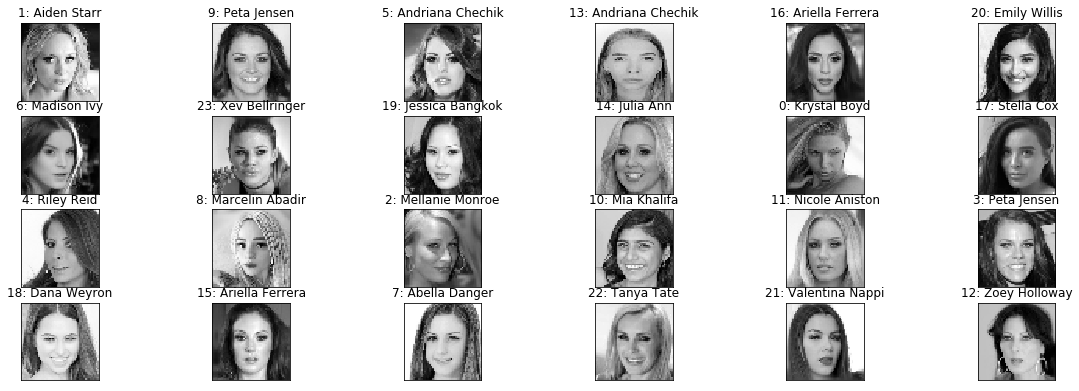

In [64]:
fig = plt.figure(figsize=(20,10))
results = {cls: [] for cls in LABELS}

# iterate over each image in test_sample
# get the model's class prediction of the image
for num, data in enumerate(test_data):
    data[0] = data[0] / 255.0
    img_data = data[0]
    img_num = data[1]
    y = fig.add_subplot(6, 6, num + 1)
    orig = img_data
    data = img_data.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
    model_out = MODEL.predict([data]).flatten()
    index = np.argmax(model_out)
    # generate output dictionary
    results = {LABELS[i]: results.get(LABELS[i]) + [model_out[i]] for i in range(NUM_CLASSES)}
    IMAGE_IDs.append(img_num)
    
    # cross-reference the predicted class-index to its class-label (for each test image)
    class_label = CLASS_INDEX.get(index, 'Invalid class!')
    print(f"Image ID: {img_num}\t | Prediction: {class_label}")

    y.imshow(orig, cmap='gray')
    plt.title(f'{img_num}: {class_label}')
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()
# plt.savefig('Class Results')

In [65]:
imgs = [img.split('.')[0] for img in next(os.walk(ALIGNED_TEST_DIR))[2]]

### Tabulated Prediction Probabilities

In [66]:
# Creates a HeatMap using the seaborn library
cm = sns.light_palette("blue", as_cmap=True)
df = pd.DataFrame.from_dict(results, orient='index', columns=imgs)
df.style.\
    format("{:.2%}").\
    set_caption('Confidence Values')\
    .background_gradient(cmap=cm)

,Aiden Starr,Allie Haze,Andriana Chechik,Anna,Ariella Ferrera,Emily Willis,Evelina Darling,Jessa Rhodes,Jessica Bangkok,Julia Ann,Krystal Boyd,Lana Rhoades,Madison Ivy,Marcelin Abadir,Mellanie Monroe,Mia Khalifa,Nicole Aniston,Peta Jensen,Riley Reid,Samantha Ryan,Stella Cox,Tanya Tate,Valentina Nappi,Zoey Holloway
Abella Danger,0.00%,0.00%,0.00%,0.00%,0.05%,0.07%,0.00%,2.31%,0.00%,0.00%,0.12%,0.49%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.01%,0.00%,78.33%,0.00%,0.00%,0.00%
Aiden Starr,94.18%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,1.20%,0.00%,7.16%,0.01%,0.00%,0.00%,0.73%,0.05%,0.00%,0.33%,0.00%,0.07%,0.00%,0.00%,0.26%,0.00%,0.00%
Aidra Fox,0.00%,0.00%,0.00%,0.01%,0.00%,3.80%,0.01%,0.00%,0.00%,0.00%,0.07%,0.28%,0.04%,0.00%,0.01%,0.00%,0.00%,0.00%,0.01%,0.00%,0.16%,0.00%,0.00%,0.00%
Aletta Ocean,0.00%,0.00%,0.00%,0.00%,0.00%,0.14%,0.00%,0.00%,0.00%,0.00%,0.00%,0.08%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.01%,0.00%,0.00%,0.00%,0.00%,0.00%
Alina Lopez,0.00%,0.00%,0.00%,0.00%,0.00%,0.50%,0.00%,0.47%,0.02%,0.00%,0.12%,6.16%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.45%,0.00%,0.85%,0.00%,0.00%,0.00%
Allie Haze,0.00%,18.30%,0.00%,11.09%,0.00%,0.00%,0.08%,2.56%,0.00%,0.00%,0.01%,0.20%,1.29%,0.00%,0.00%,0.00%,0.00%,1.96%,0.20%,0.00%,11.33%,0.00%,0.00%,0.00%
Amirah Adara,0.00%,0.00%,0.00%,0.00%,0.31%,0.01%,0.00%,0.12%,1.03%,0.00%,0.01%,32.52%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,1.29%,0.09%,2.97%,0.00%,0.00%,0.00%
Andriana Chechik,0.00%,0.07%,99.96%,82.06%,0.04%,0.13%,0.04%,0.00%,0.00%,0.00%,0.01%,0.16%,15.14%,0.00%,0.00%,0.00%,0.00%,0.06%,0.04%,0.12%,0.05%,0.00%,0.00%,0.01%
Ariella Ferrera,0.00%,0.00%,0.00%,0.00%,98.15%,0.00%,0.00%,0.36%,0.00%,0.00%,0.00%,0.45%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.03%,97.44%,0.18%,0.00%,0.00%,0.00%
Brenda James,0.01%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.19%,0.00%,0.00%,0.00%,16.33%,0.00%,0.00%,0.00%,0.80%,0.00%,0.00%,0.00%,0.00%,0.00%


In [67]:
"""
Re-structures the results dictionary so that each class_label points to another dictionary {k, v}
where k = the Image_Id number and v = the confidence value
"""

def gen_results(results):
    my_dict = {}
    for cls in LABELS:
        probs = iter(results[cls])
        my_dict.update({cls: {}})
        for k in IMAGE_IDs:
            my_dict[cls][int(k)] = next(probs)

    return my_dict

In [68]:
def get_top5(results, ID=1):
    results = gen_results(results)
    probs = np.array([(results[k][ID]) for k in results])
    # print(f'Reverse: {(-probs).argsort()} - {sorted(probs, reverse=True)}')
    indices = (-probs).argsort()[:5] # sorts probabilities (largest - smallest) + returns their corresponding array indices
    top_5 = [CLASS_INDEX.get(i) for i in indices]
    return top_5

In [69]:
Image_ID = 7
TOP_5 = get_top5(results, Image_ID)
TOP_5

['Abella Danger',
 'Allie Haze',
 'Amirah Adara',
 'Evelina Darling',
 'Stella Cox']

# Get Overall Accuracy

In [70]:
def get_overall_accuracy(results):
    i = 0
    num_correct = 0
    total = len(test_data) # total number of images
    keys = results.keys()
    class_labels = []
    
    for ID in IMAGE_IDs: # loop through each image ID
        predictions = []
        for key in list(keys): # for each model in the results dictionary
            prob = results[key].get(ID)
            predictions.append(prob)
        max_index = np.argmax(predictions) # max index
        label = CLASS_INDEX.get(max_index, 'Invalid class!')
        class_labels.append(label)
    
    for img in os.listdir(ALIGNED_TEST_DIR):
        img = img.split('.')[0].strip() # gets the class name of the image file
        if img == class_labels[i]:
            num_correct += 1
            # print(f"Image name: {img} - predicted label: {class_labels[i]}")
        print(f"Image name: {img} - predicted label: {class_labels[i]}")
        i += 1 
        
        
    accuracy = round((num_correct / total) * 100, 2)
    return f'{accuracy}%'

# Overall Accuracy

In [71]:
get_overall_accuracy(gen_results(results))

Image name: Aiden Starr - predicted label: Aiden Starr
Image name: Allie Haze - predicted label: Peta Jensen
Image name: Andriana Chechik - predicted label: Andriana Chechik
Image name: Anna - predicted label: Andriana Chechik
Image name: Ariella Ferrera - predicted label: Ariella Ferrera
Image name: Emily Willis - predicted label: Emily Willis
Image name: Evelina Darling - predicted label: Madison Ivy
Image name: Jessa Rhodes - predicted label: Xev Bellringer
Image name: Jessica Bangkok - predicted label: Jessica Bangkok
Image name: Julia Ann - predicted label: Julia Ann
Image name: Krystal Boyd - predicted label: Krystal Boyd
Image name: Lana Rhoades - predicted label: Stella Cox
Image name: Madison Ivy - predicted label: Riley Reid
Image name: Marcelin Abadir - predicted label: Marcelin Abadir
Image name: Mellanie Monroe - predicted label: Mellanie Monroe
Image name: Mia Khalifa - predicted label: Mia Khalifa
Image name: Nicole Aniston - predicted label: Nicole Aniston
Image name: P

'62.5%'